<a href="https://colab.research.google.com/github/PervejHosen/Time_Series/blob/main/Kaggle_Linear_Regression_With_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **What is a Time Series?**
* The basic object of forecasting is the time series, which is a set of observations recorded over time. In forecasting applications, the observations are typically recorded with a regular frequency, like `daily` or `monthly`.

# **Linear Regression With Time Series**

In [1]:
import pandas as pd

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/Python/Datasets/Time Series/book_sales.csv")
df.head()

Date  Paperback  Hardcover
0  2000-04-01        199        139
1  2000-04-02        172        128
2  2000-04-03        111        172
3  2000-04-04        209        139
4  2000-04-05        161        191

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       30 non-null     object
 1   Paperback  30 non-null     int64 
 2   Hardcover  30 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 848.0+ bytes


In [5]:
df = pd.read_csv("/content/drive/MyDrive/Python/Datasets/Time Series/book_sales.csv",
    index_col='Date',
    parse_dates=['Date']).drop('Paperback', axis=1)

df.head()

Hardcover
Date                 
2000-04-01        139
2000-04-02        128
2000-04-03        172
2000-04-04        139
2000-04-05        191

**Datset Info:**
* This series records the number of hardcover book sales at a retail store over 30 days. Notice that we have a single column of observations Hardcover with a time index Date.

## **Linear Regression with Time Series**

* For the first part of this course, we'll use the linear regression algorithm to construct forecasting models. Linear regression is widely used in practice and adapts naturally to even complex forecasting tasks.

* The linear regression algorithm learns how to make a weighted sum from its input features. For two features, we would have:

   `target = weight_1 * feature_1 + weight_2 * feature_2 + bias`

* During training, the regression algorithm learns values for the parameters `weight_1, weight_2`, and `bias` that best fit the target. (This algorithm is often called ordinary least squares since it chooses values that minimize the squared error between the target and the predictions.) The weights are also called regression coefficients and the bias is also called the intercept because it tells you where the graph of this function crosses the y-axis.

## **Time-step features**

There are two kinds of features unique to time series:
  * `time-step features` and
  * `lag features`.

Time-step features are features we can derive directly from the time index. The most basic time-step feature is the time dummy, which counts off time steps in the series from beginning to end.

In [6]:
import numpy as np

df['Time'] = np.arange(len(df.index))

df.head()

Hardcover  Time
Date                       
2000-04-01        139     0
2000-04-02        128     1
2000-04-03        172     2
2000-04-04        139     3
2000-04-05        191     4

**Linear regression with the time dummy produces the model:**

`target = weight * time + bias`

The time dummy then lets us fit curves to time series in a time plot, where Time forms the x-axis.

<ipython-input-7-2fdd31d63dc8>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


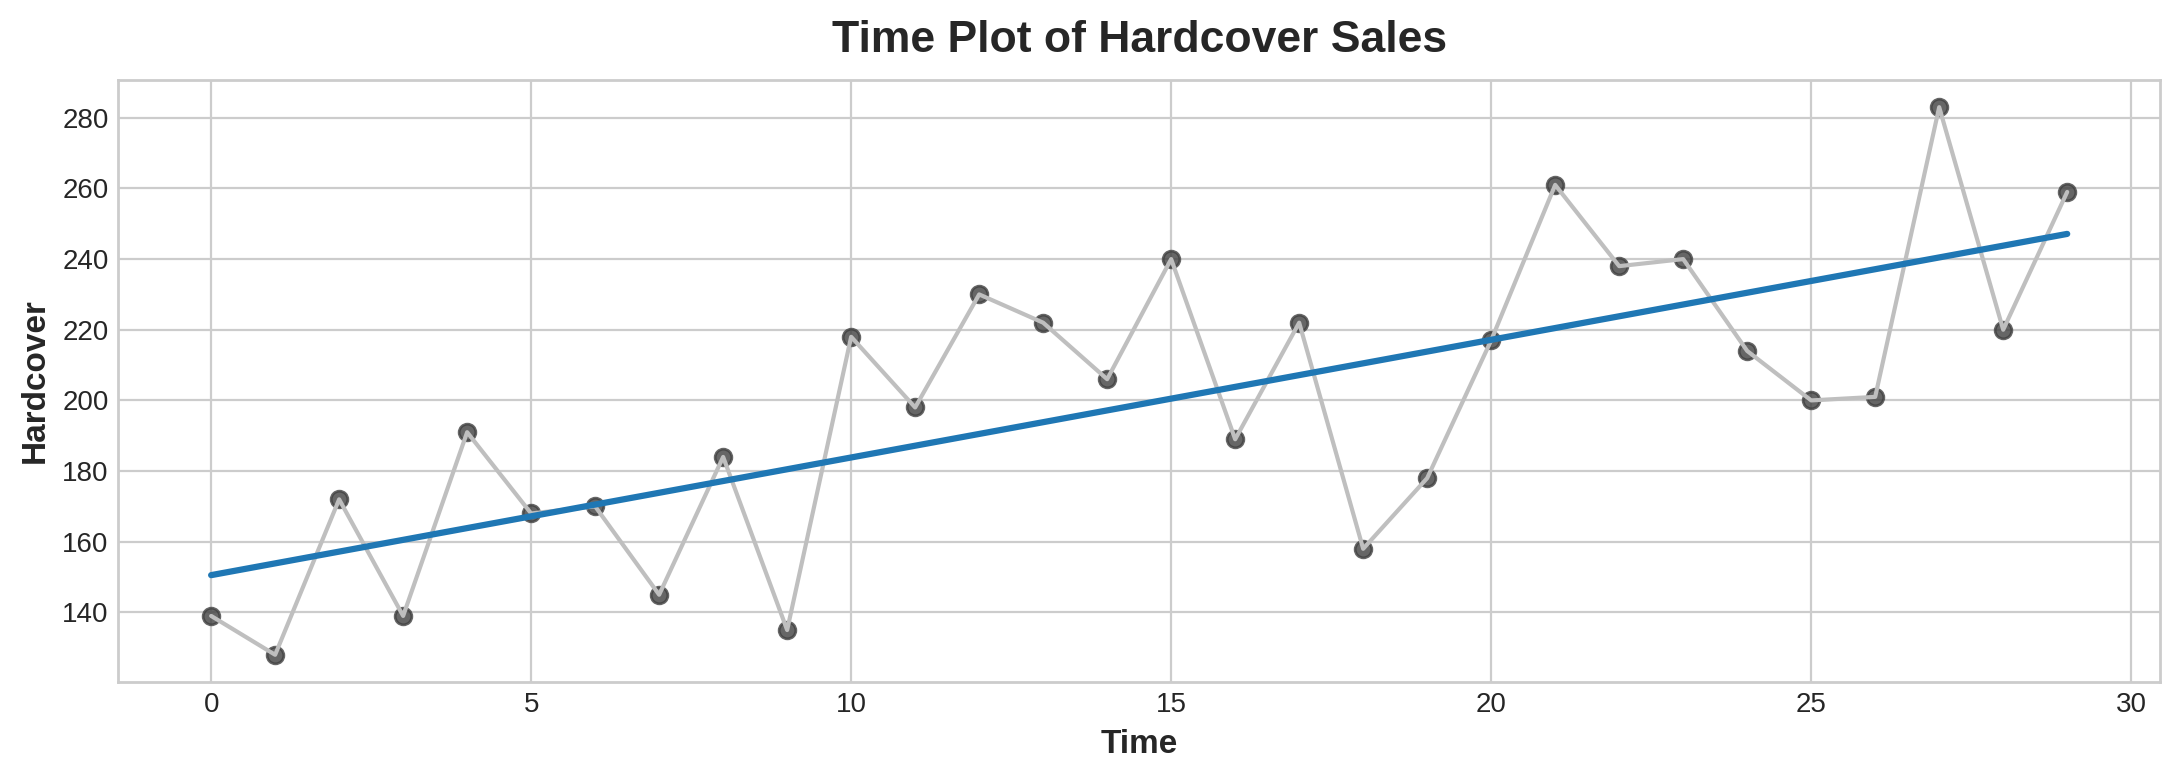

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=df, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Hardcover Sales');

**Info:**
* Time-step features let's model time dependence.
* A series is time dependent if its values can be predicted from the time they occured.
* In the Hardcover Sales series, we can predict that sales later in the month are generally higher than sales earlier in the month.

## **Lag features**

* To make a lag feature we shift the observations of the target series so that they appear to have occured later in time.
* Here we've created a 1-step lag feature, though shifting by multiple steps is possible too.

In [8]:
df['Lag_1'] = df['Hardcover'].shift(1)
df = df.reindex(columns=['Hardcover', 'Lag_1'])

df.head()

Hardcover  Lag_1
Date                        
2000-04-01        139    NaN
2000-04-02        128  139.0
2000-04-03        172  128.0
2000-04-04        139  172.0
2000-04-05        191  139.0

**Linear regression with a lag feature produces the model:**

`target = weight * lag + bias`

So lag features let us fit curves to lag plots where each observation in a series is plotted against the previous observation.

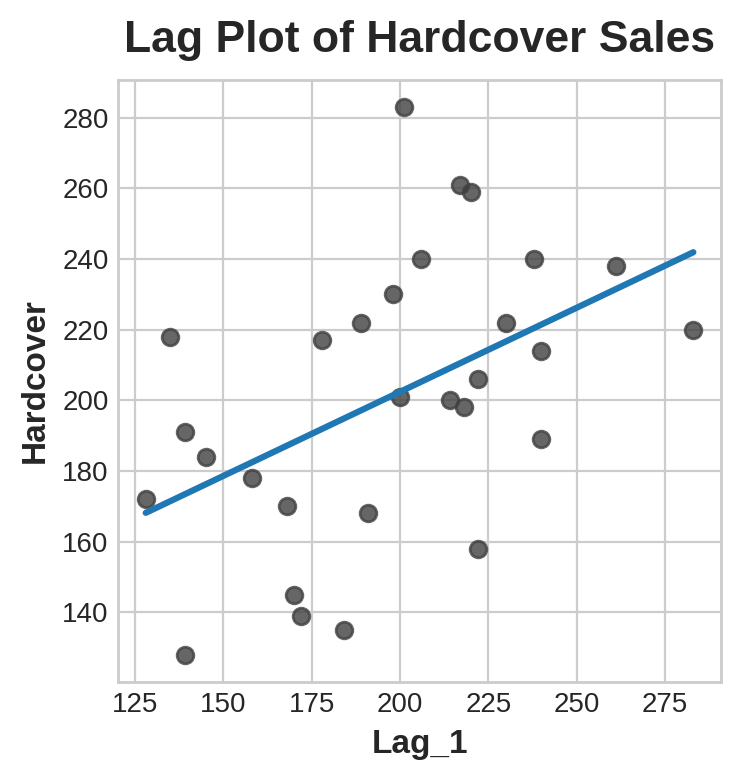

In [9]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Hardcover Sales');

**Info:**
* We can see from the lag plot that sales on one day (Hardcover) are correlated with sales from the previous day (Lag_1).
* When you see a relationship like this, you know a lag feature will be useful.

More generally, lag features let us model serial dependence. A time series has serial dependence when an observation can be predicted from previous observations. In Hardcover Sales, we can predict that high sales on one day usually mean high sales the next day.

Adapting machine learning algorithms to time series problems is largely about feature engineering with the time index and lags. For most of the course, we use linear regression for its simplicity, but these features will be useful whichever algorithm you choose for your forecasting task.

## **Example - Tunnel Traffic**

Tunnel Traffic is a time series describing the number of vehicles traveling through the Baregg Tunnel in Switzerland each day from November 2003 to November 2005. In this example, we'll get some practice applying linear regression to time-step features and lag features.

In [10]:
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Load Tunnel Traffic dataset
tunnel = pd.read_csv("/content/drive/MyDrive/Python/Datasets/Time Series/tunnel.csv", parse_dates=["Day"])

# Create a time series in Pandas by setting the index to a date
# column. We parsed "Day" as a date type by using `parse_dates` when
# loading the data.
tunnel = tunnel.set_index("Day")

# By default, Pandas creates a `DatetimeIndex` with dtype `Timestamp`
# (equivalent to `np.datetime64`, representing a time series as a
# sequence of measurements taken at single moments. A `PeriodIndex`,
# on the other hand, represents a time series as a sequence of
# quantities accumulated over periods of time. Periods are often
# easier to work with, so that's what we'll use in this course.
tunnel = tunnel.to_period()

tunnel.head()

NumVehicles
Day                    
2003-11-01       103536
2003-11-02        92051
2003-11-03       100795
2003-11-04       102352
2003-11-05       106569

**Time-step feature**

Provided the time series doesn't have any missing dates, we can create a time dummy by counting out the length of the series.

In [11]:
df = tunnel.copy()

df['Time'] = np.arange(len(tunnel.index))

df.head()

NumVehicles  Time
Day                          
2003-11-01       103536     0
2003-11-02        92051     1
2003-11-03       100795     2
2003-11-04       102352     3
2003-11-05       106569     4

**Info:**
* The procedure for fitting a linear regression model follows the standard steps for scikit-learn.

In [12]:
from sklearn.linear_model import LinearRegression

# Training data
X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'NumVehicles']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

**The model actually created is (approximately):**

`Vehicles = 22.5 * Time + 98176. `

Plotting the fitted values over time shows us how fitting linear regression to the time dummy creates the trend line defined by this equation.

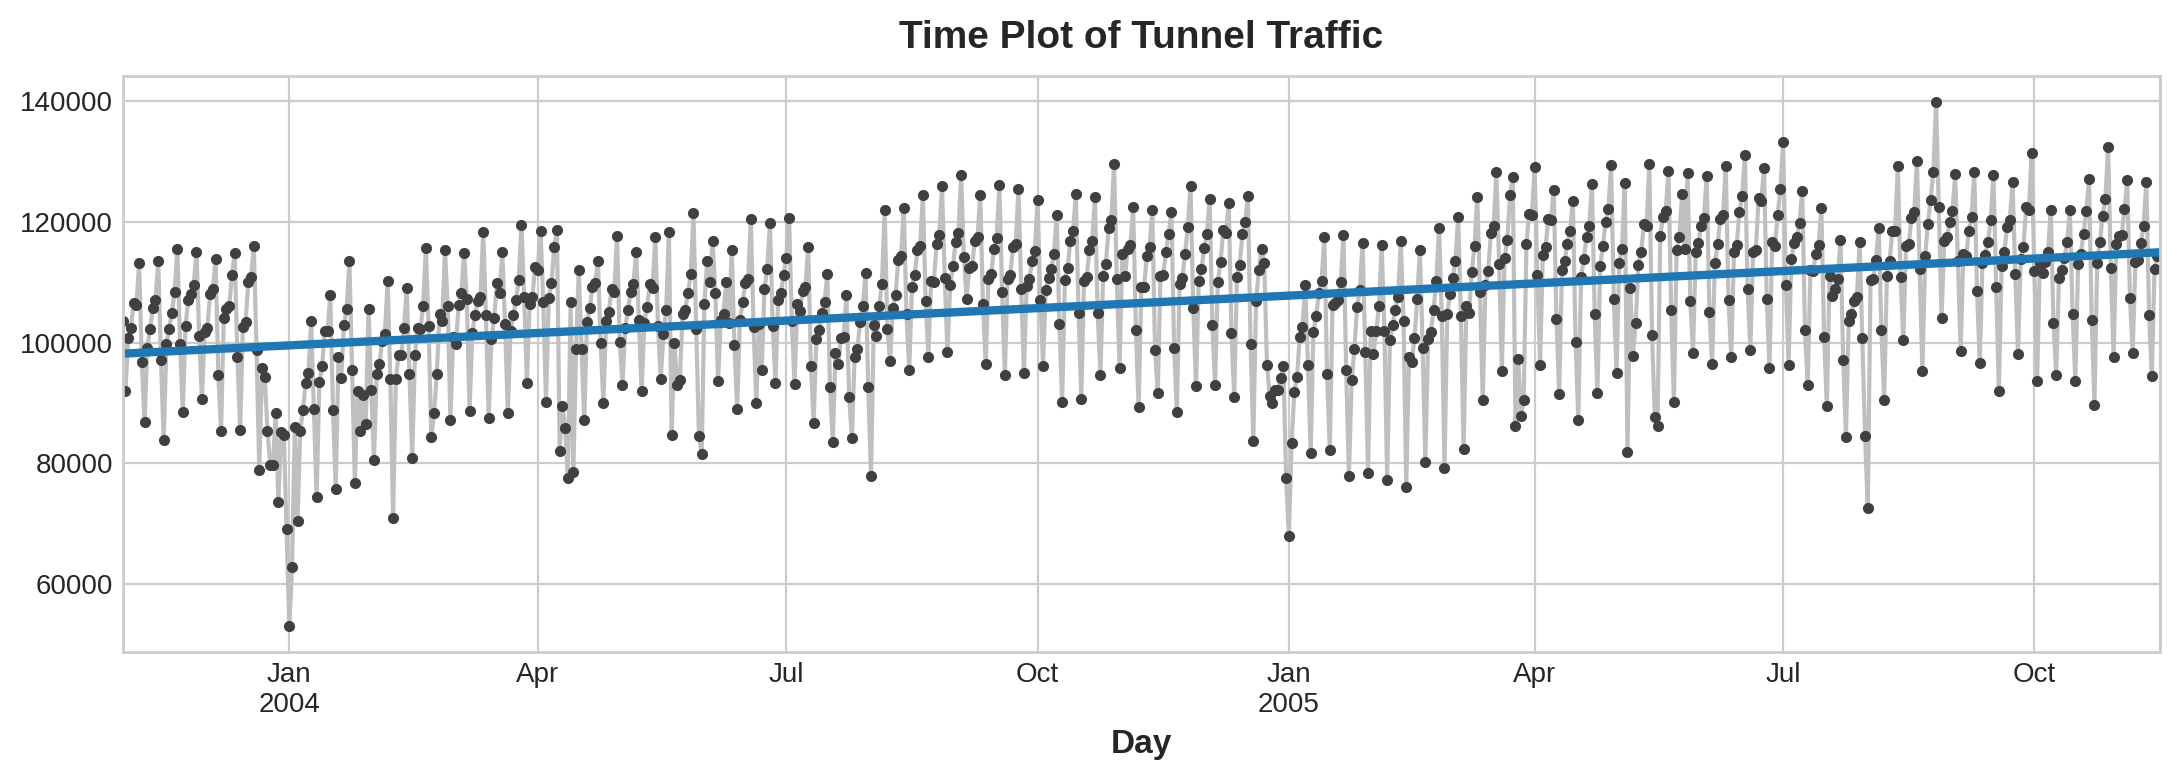

In [13]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Tunnel Traffic');

**Lag feature**

Pandas provides us a simple method to lag a series, the shift method.

In [14]:
df['Lag_1'] = df['NumVehicles'].shift(1)
df.head()

NumVehicles  Time     Lag_1
Day                                    
2003-11-01       103536     0       NaN
2003-11-02        92051     1  103536.0
2003-11-03       100795     2   92051.0
2003-11-04       102352     3  100795.0
2003-11-05       106569     4  102352.0

**Info:**
* When creating lag features, we need to decide what to do with the missing values produced.
* Filling them in is one option, maybe with 0.0 or "backfilling" with the first known value.
* Instead, we'll just drop the missing values, making sure to also drop values in the target from corresponding dates.

In [15]:
from sklearn.linear_model import LinearRegression

X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'NumVehicles']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

The lag plot shows us how well we were able to fit the relationship between the number of vehicles one day and the number the previous day.

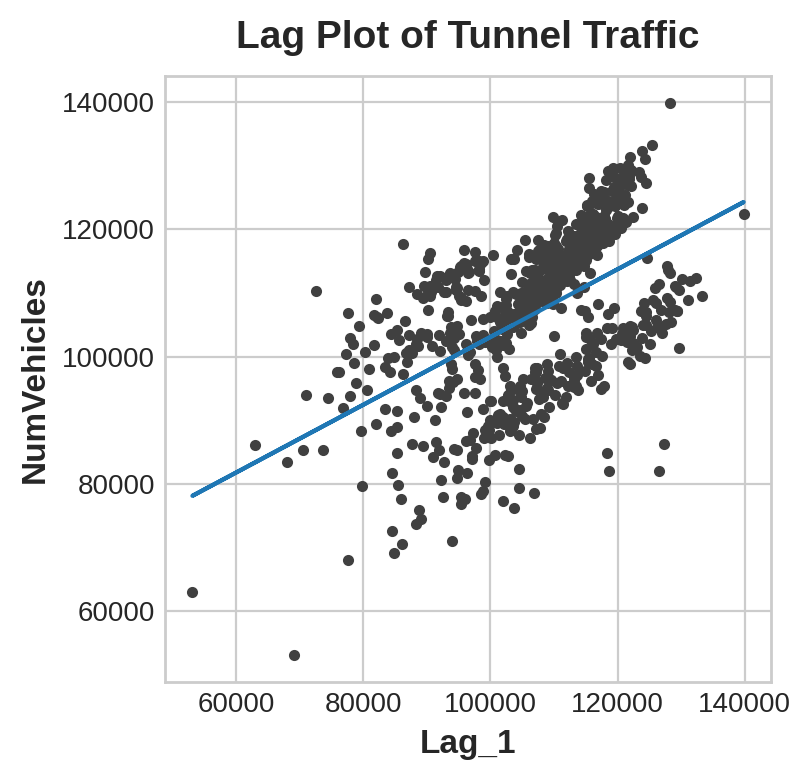

In [16]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Tunnel Traffic');

**Info:**
* What does this prediction from a lag feature mean about how well we can predict the series across time?
* The following time plot shows us how our forecasts now respond to the behavior of the series in the recent past.

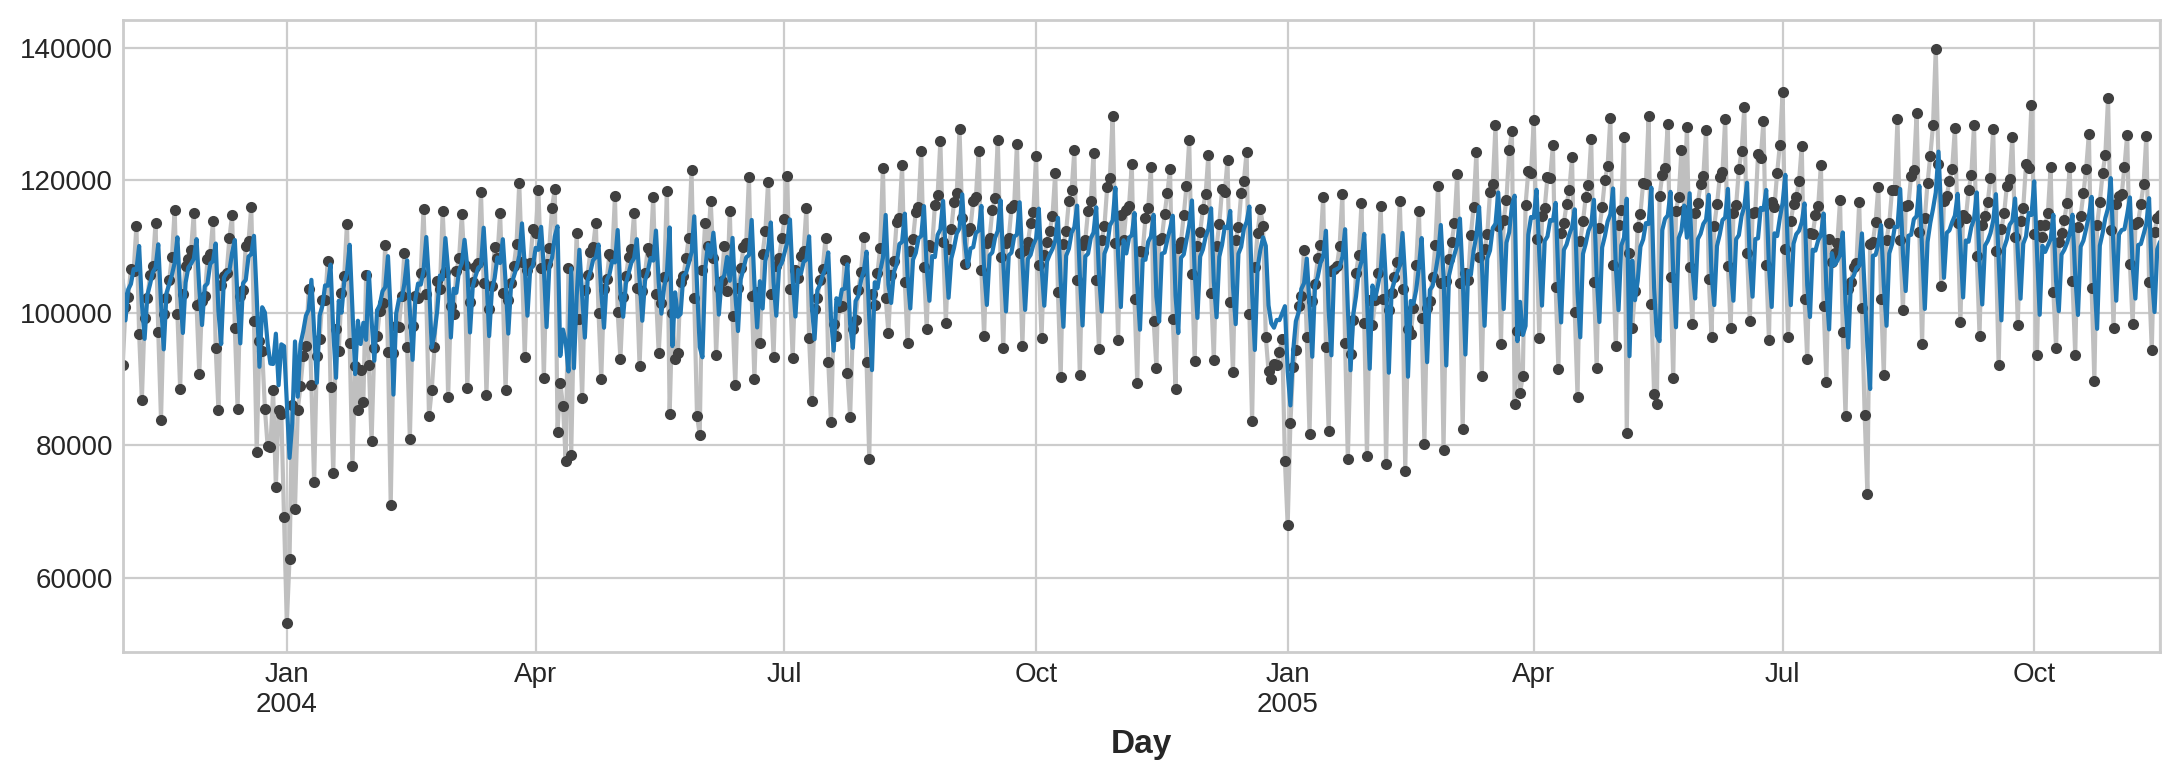

In [17]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

**Info:**
* The best time series models will usually include some combination of time-step features and lag features.

Over the next few lessons, we'll learn how to engineer features modeling the most common patterns in time series using the features from this lesson as a starting point.

# **Trend**

## **What is Trend?**

* The trend component of a time series represents a persistent, long-term change in the mean of the series.
* The trend is the slowest-moving part of a series, the part representing the largest time scale of importance.

* In a time series of product sales, an increasing trend might be the effect of a market expansion as more people become aware of the product year by year.

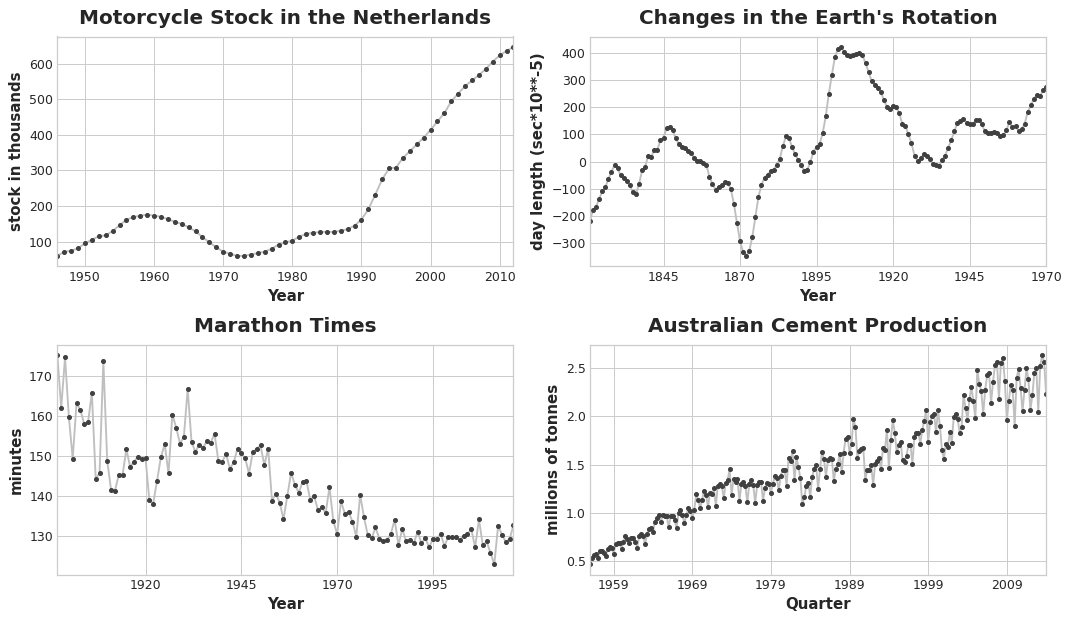

* In this course, we'll focus on trends in the mean.
* More generally though, any persistent and slow-moving change in a series could constitute a trend.
* time series commonly have trends in their variation for instance.

## **Moving Average Plots**

To see what kind of trend a time series might have, we can use a `moving average plot`. To compute a moving average of a time series, we compute the average of the values within a sliding window of some defined width. Each point on the graph represents the average of all the values in the series that fall within the window on either side. The idea is to smooth out any short-term fluctuations in the series so that only long-term changes remain.

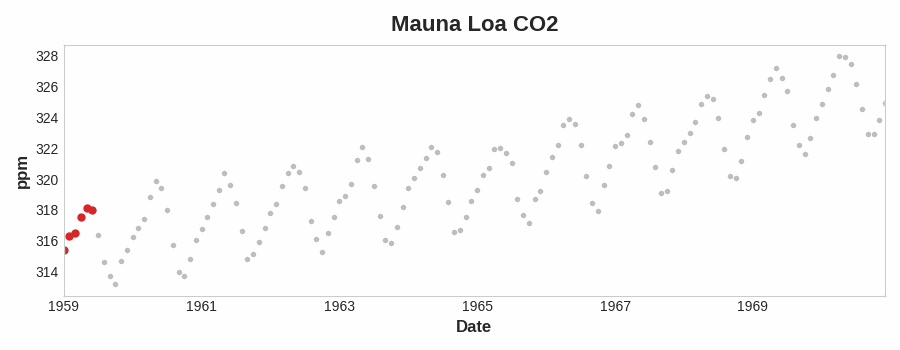

*A moving average plot illustrating a linear trend. Each point on the curve (blue) is the average of the points (red) within a window of size 12.*

**Info:**
* Notice how the Mauna Loa series above has a repeating up and down movement year after year -- short-term, seasonal change.
* For a change to be a part of the trend, it should occur over a longer period than any seasonal changes.
* To visualize a trend, therefore, we take an average over a period longer than any seasonal period in the series.
* For the Mauna Loa series, we chose a window of size 12 to smooth over the season within each year.

## **Engineering Trend**

Once we've identified the shape of the trend, we can attempt to model it using a `time-step feature`. We've already seen how using the time dummy itself will model a linear trend:

    `target = a * time + b`

We can fit many other kinds of trend through transformations of the time dummy. If the trend appears to be `quadratic (a parabola)`, we just need to add the square of the time dummy to the feature set, giving us:

    `target = a * time ** 2 + b * time + c`

Linear regression will learn the coefficients `a, b, and c`.

The trend curves in the figure below were both fit using these kinds of features and scikit-learn's LinearRegression:

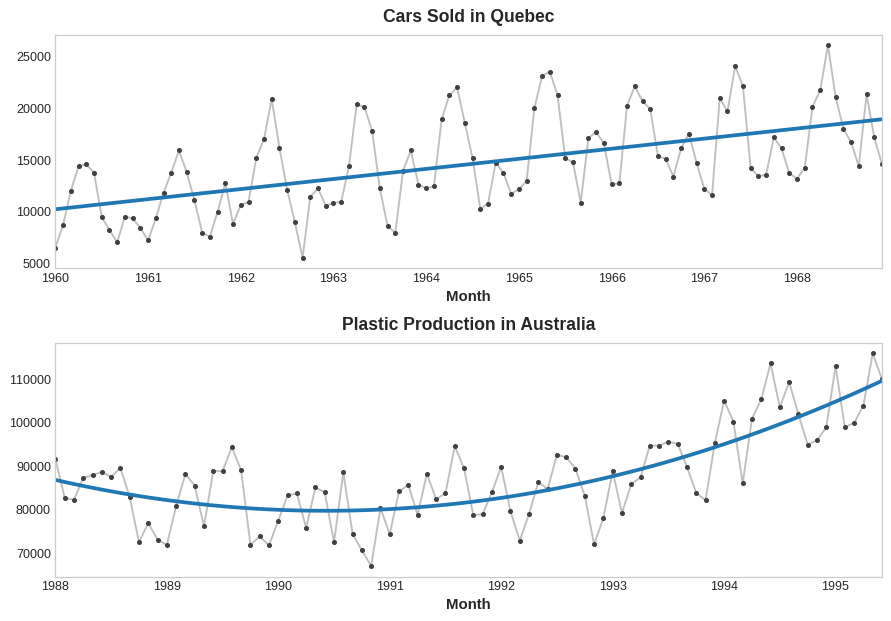

***Top:*** Series with a linear trend. ***Below:*** Series with a quadratic trend.


If you haven't seen the trick before, you may not have realized that linear regression can fit curves other than lines. The idea is that if you can provide curves of the appropriate shape as features, then linear regression can learn how to combine them in the way that best fits the target.

## **Example - Tunnel Traffic**

In this example we'll create a trend model for the Tunnel Traffic dataset.

In [20]:
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Load Tunnel Traffic dataset
tunnel = pd.read_csv("/content/drive/MyDrive/Python/Datasets/Time Series/tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period()
tunnel.head()

NumVehicles
Day                    
2003-11-01       103536
2003-11-02        92051
2003-11-03       100795
2003-11-04       102352
2003-11-05       106569

**Info:**
* Let's make a moving average plot to see what kind of trend this series has.
* Since this series has daily observations, let's choose a window of 365 days to smooth over any short-term changes within the year.

* To create a moving average, first use the rolling method to begin a windowed computation.
* Follow this by the mean method to compute the average over the window.
* As we can see, the trend of Tunnel Traffic appears to be about linear.

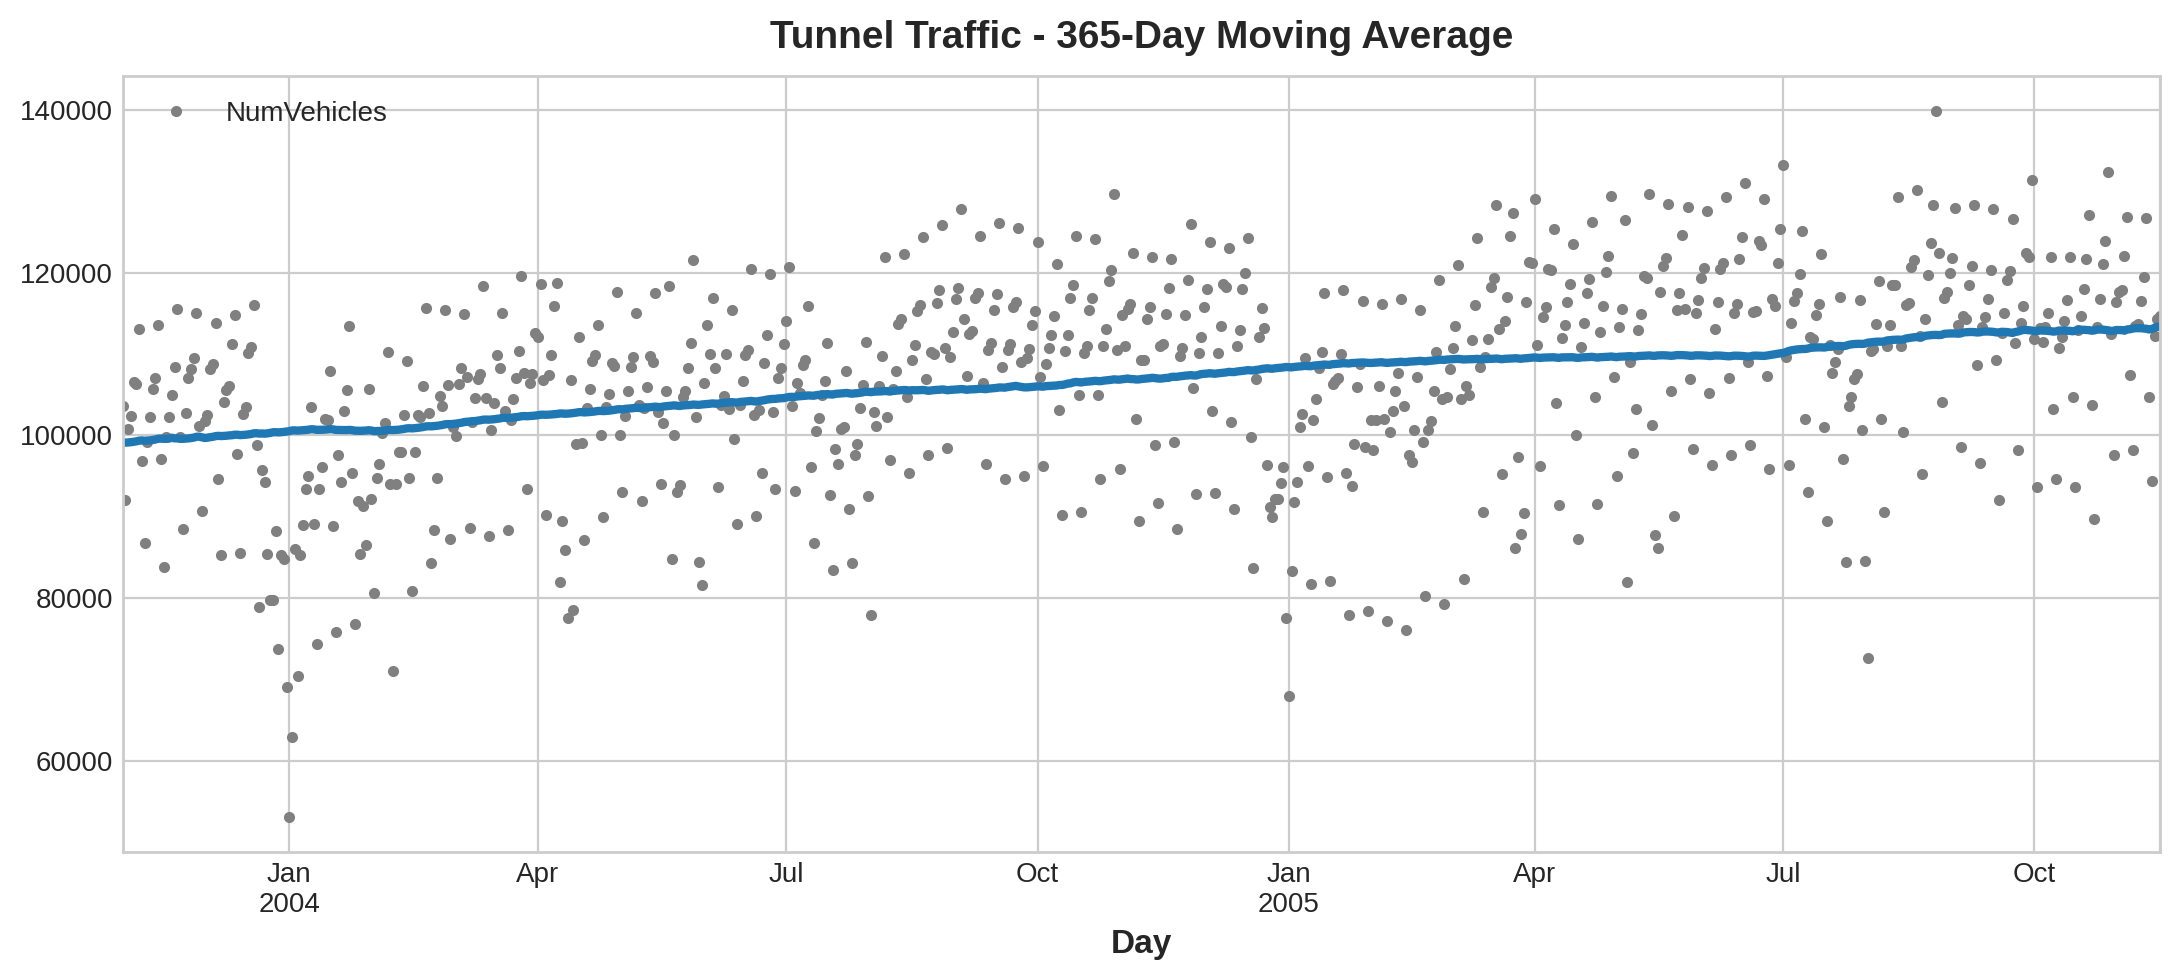

In [21]:
moving_average = tunnel.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = tunnel.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

**Info:**
* In Lesson 1, we engineered our time dummy in Pandas directly. From now on, however, we'll use a function from the statsmodels library called DeterministicProcess.
* Using this function will help us avoid some tricky failure cases that can arise with time series and linear regression.
* The order argument refers to polynomial order: 1 for linear, 2 for quadratic, 3 for cubic, and so on.

In [22]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=tunnel.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

const  trend
Day                     
2003-11-01    1.0    1.0
2003-11-02    1.0    2.0
2003-11-03    1.0    3.0
2003-11-04    1.0    4.0
2003-11-05    1.0    5.0

(A deterministic process, by the way, is a technical term for a time series that is non-random or completely determined, like the const and trend series are. Features derived from the time index will generally be deterministic.)

We create our trend model basically as before, though note the addition of the fit_intercept=False argument.

In [23]:
from sklearn.linear_model import LinearRegression

y = tunnel["NumVehicles"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

The trend discovered by our LinearRegression model is almost identical to the moving average plot, which suggests that a linear trend was the right decision in this case.

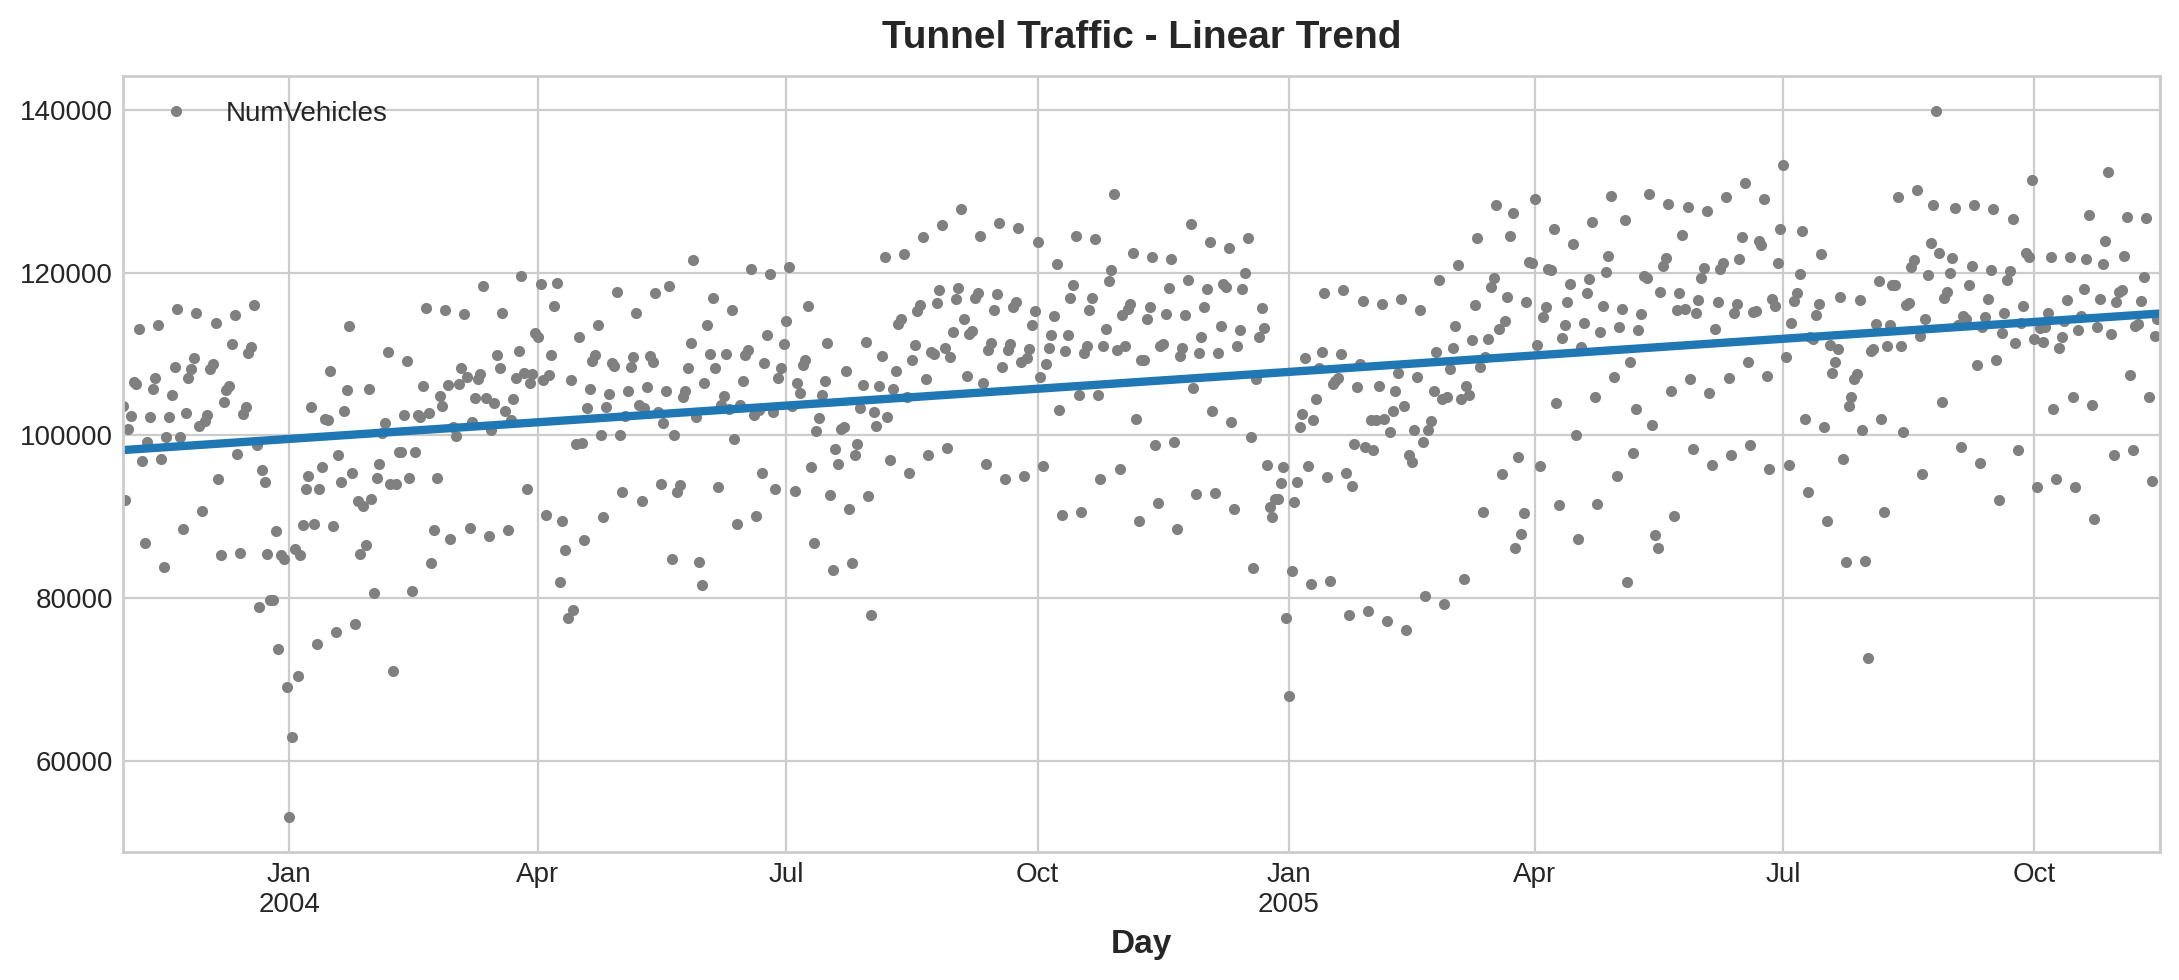

In [24]:
ax = tunnel.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

**Info:**
* To make a forecast, we apply our model to "out of sample" features. "Out of sample" refers to times outside of the observation period of the training data. Here's how we could make a 30-day forecast:

In [25]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

Let's plot a portion of the series to see the trend forecast for the next 30 days:

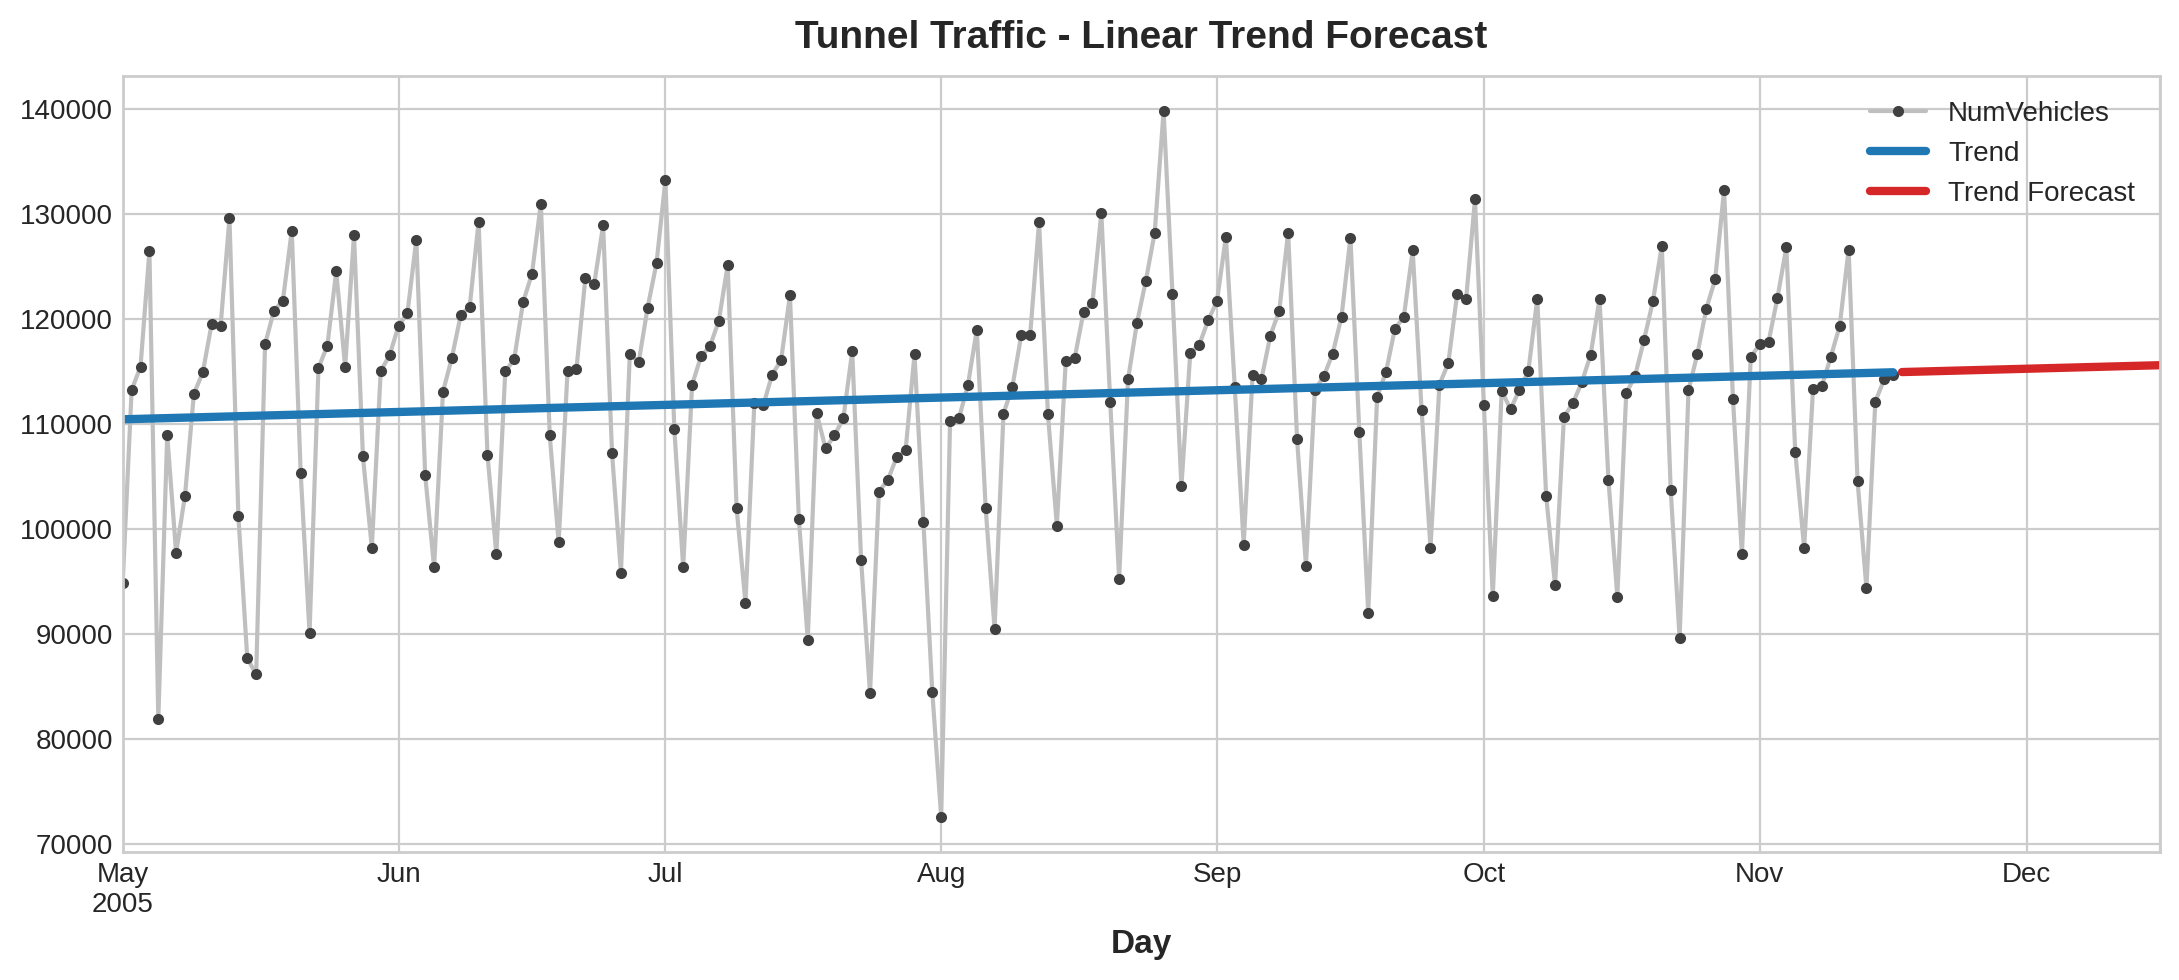

In [26]:
ax = tunnel["2005-05":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

**Info:**
* The trend models we learned about in this lesson turn out to be useful for a number of reasons. Besides acting as a baseline or starting point for more sophisticated models, we can also use them as a component in a "hybrid model" with algorithms unable to learn trends (like XGBoost and random forests). We'll learn more about this technique in Lesson 5.

# **Seasonality**

## **What is Seasonality?**

We say that a time series exhibits seasonality whenever there is a regular, periodic change in the mean of the series. Seasonal changes generally follow the clock and calendar -- repetitions over a day, a week, or a year are common. Seasonality is often driven by the cycles of the natural world over days and years or by conventions of social behavior surrounding dates and times.

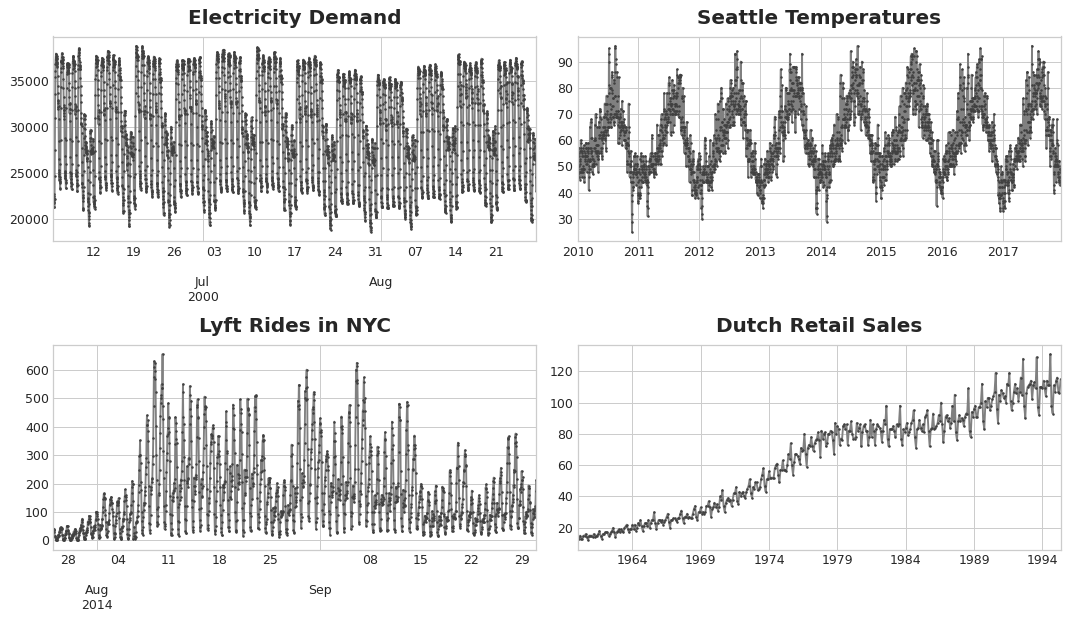

`Seasonal patterns in four time series`.

We will learn two kinds of features that model seasonality. The first kind, indicators, is best for a season with few observations, like a weekly season of daily observations. The second kind, Fourier features, is best for a season with many observations, like an annual season of daily observations.

## **Seasonal Plots**

Just like we used a moving average plot to discover the trend in a series, we can use a seasonal plot to discover seasonal patterns.

A seasonal plot shows segments of the time series plotted against some common period, the period being the "season" you want to observe. The figure shows a seasonal plot of the daily views of Wikipedia's article on Trigonometry: the article's daily views plotted over a common weekly period.

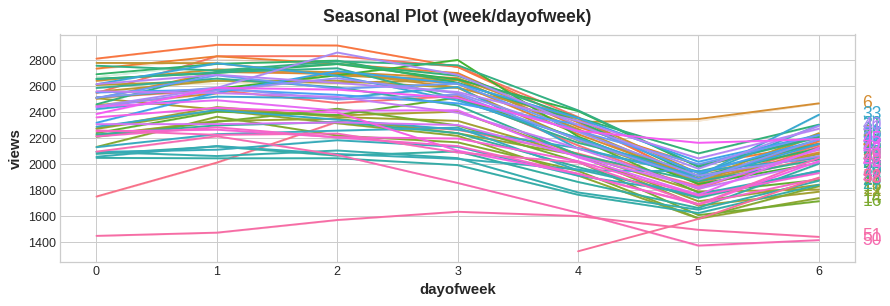

`There is a clear weekly seasonal pattern in this series, higher on weekdays and falling towards the weekend`.

## **Seasonal indicators**

Seasonal indicators are binary features that represent seasonal differences in the level of a time series. Seasonal indicators are what you get if you treat a seasonal period as a categorical feature and apply one-hot encoding.

By one-hot encoding days of the week, we get weekly seasonal indicators. Creating weekly indicators for the Trigonometry series will then give us six new "dummy" features. (Linear regression works best if you drop one of the indicators; we chose Monday in the frame below.)

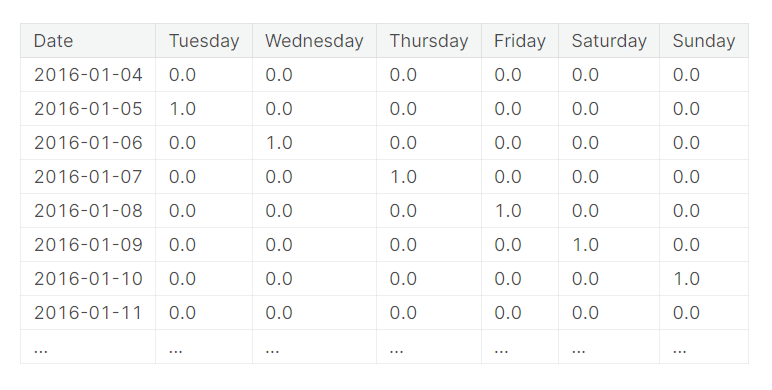

Adding seasonal indicators to the training data helps models distinguish means within a seasonal period:

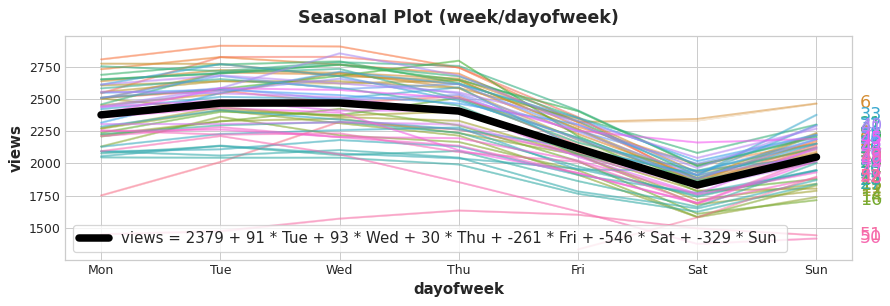

`Ordinary linear regression learns the mean values at each time in the season`.

The indicators act as On / Off switches. At any time, at most one of these indicators can have a value of 1 (On). Linear regression learns a baseline value 2379 for Mon and then adjusts by the value of whichever indicator is On for that day; the rest are 0 and vanish.

## **Fourier Features and the Periodogram**

The kind of feature we discuss now are better suited for long seasons over many observations where indicators would be impractical. Instead of creating a feature for each date, Fourier features try to capture the overall shape of the seasonal curve with just a few features.

Let's take a look at a plot for the annual season in Trigonometry. Notice the repetitions of various frequencies: a long up-and-down movement three times a year, short weekly movements 52 times a year, and perhaps others.

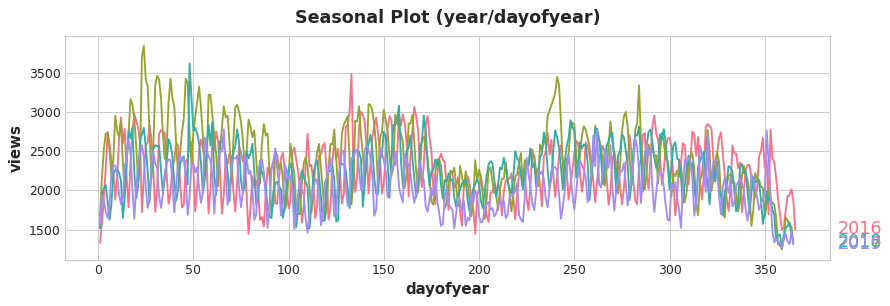
`Annual seasonality in the Wiki Trigonometry series`.

It is these frequencies within a season that we attempt to capture with Fourier features. The idea is to include in our training data periodic curves having the same frequencies as the season we are trying to model. The curves we use are those of the trigonometric functions sine and cosine.

## **Fourier features**
Fourier features are pairs of sine and cosine curves, one pair for each potential frequency in the season starting with the longest. Fourier pairs modeling annual seasonality would have frequencies: once per year, twice per year, three times per year, and so on.

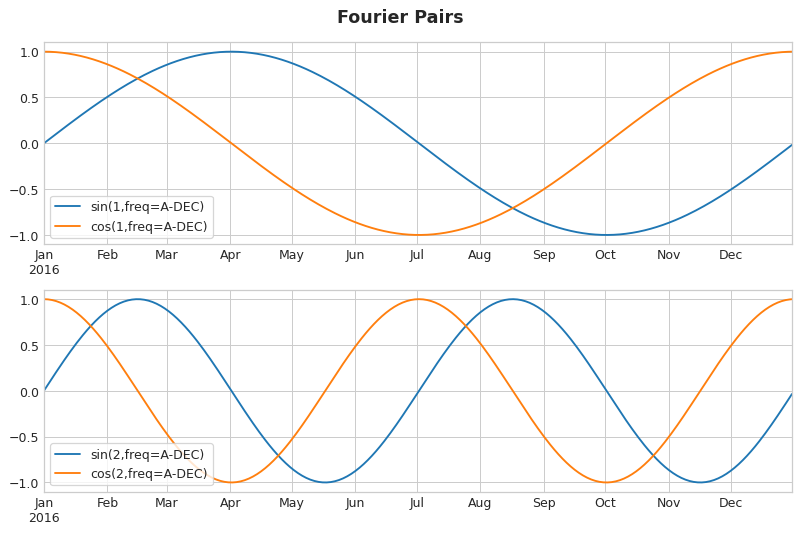

`The first two Fourier pairs for annual seasonality. Top: Frequency of once per year. Bottom: Frequency of twice per year`.

If we add a set of these sine / cosine curves to our training data, the linear regression algorithm will figure out the weights that will fit the seasonal component in the target series. The figure illustrates how linear regression used four Fourier pairs to model the annual seasonality in the Wiki Trigonometry series.

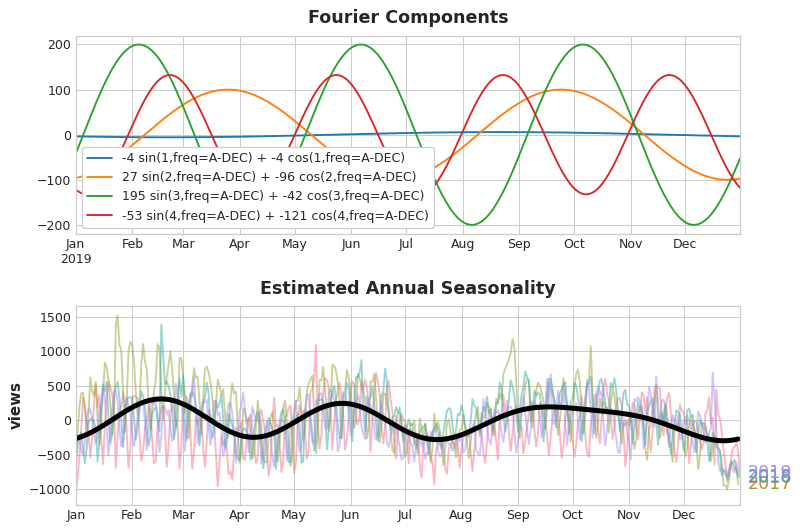

**Top:** Curves for four Fourier pairs, a sum of sine and cosine with regression coefficients. Each curve models a different frequency. **Bottom:** The sum of these curves approximates the seasonal pattern.

Notice that we only needed eight features (four sine / cosine pairs) to get a good estimate of the annual seasonality. Compare this to the seasonal indicator method which would have required hundreds of features (one for each day of the year). By modeling only the "main effect" of the seasonality with Fourier features, you'll usually need to add far fewer features to your training data, which means reduced computation time and less risk of overfitting.

## **Choosing Fourier features with the Periodogram**

How many Fourier pairs should we actually include in our feature set? We can answer this question with the periodogram. The **periodogram** tells you the strength of the frequencies in a time series. Specifically, the value on the y-axis of the graph is `(a ** 2 + b ** 2) / 2,` where `a and b` are the coefficients of the sine and cosine at that frequency (as in the Fourier Components plot above).

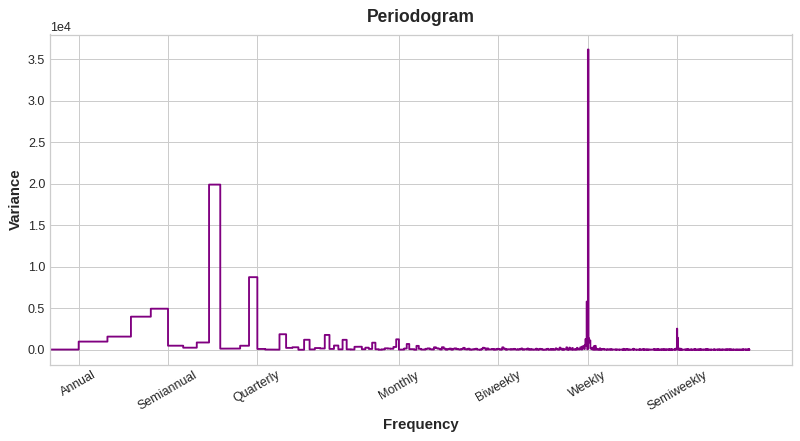

`Periodogram for the Wiki Trigonometry series`.

From left to right, the periodogram drops off after Quarterly, four times a year. That was why we chose four Fourier pairs to model the annual season. The Weekly frequency we ignore since it's better modeled with indicators.

## **Computing Fourier features (optional)**

Knowing how Fourier features are computed isn't essential to using them, but if seeing the details would clarify things, the cell hidden cell below illustrates how a set of Fourier features could be derived from the index of a time series. (We'll use a library function from `statsmodels` for our applications, however.)

In [1]:
import numpy as np


def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)


# Compute Fourier features to the 4th order (8 new features) for a
# series y with daily observations and annual seasonality:
#
# fourier_features(y, freq=365.25, order=4)

## **Example - Tunnel Traffic**

We'll continue once more with the Tunnel Traffic dataset. This hidden cell loads the data and defines two functions: `seasonal_plot` and `plot_periodogram`.

In [5]:
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


tunnel = pd.read_csv("/content/drive/MyDrive/Python/Datasets/Time Series/tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period("D")

Let's take a look at seasonal plots over a week and over a year.

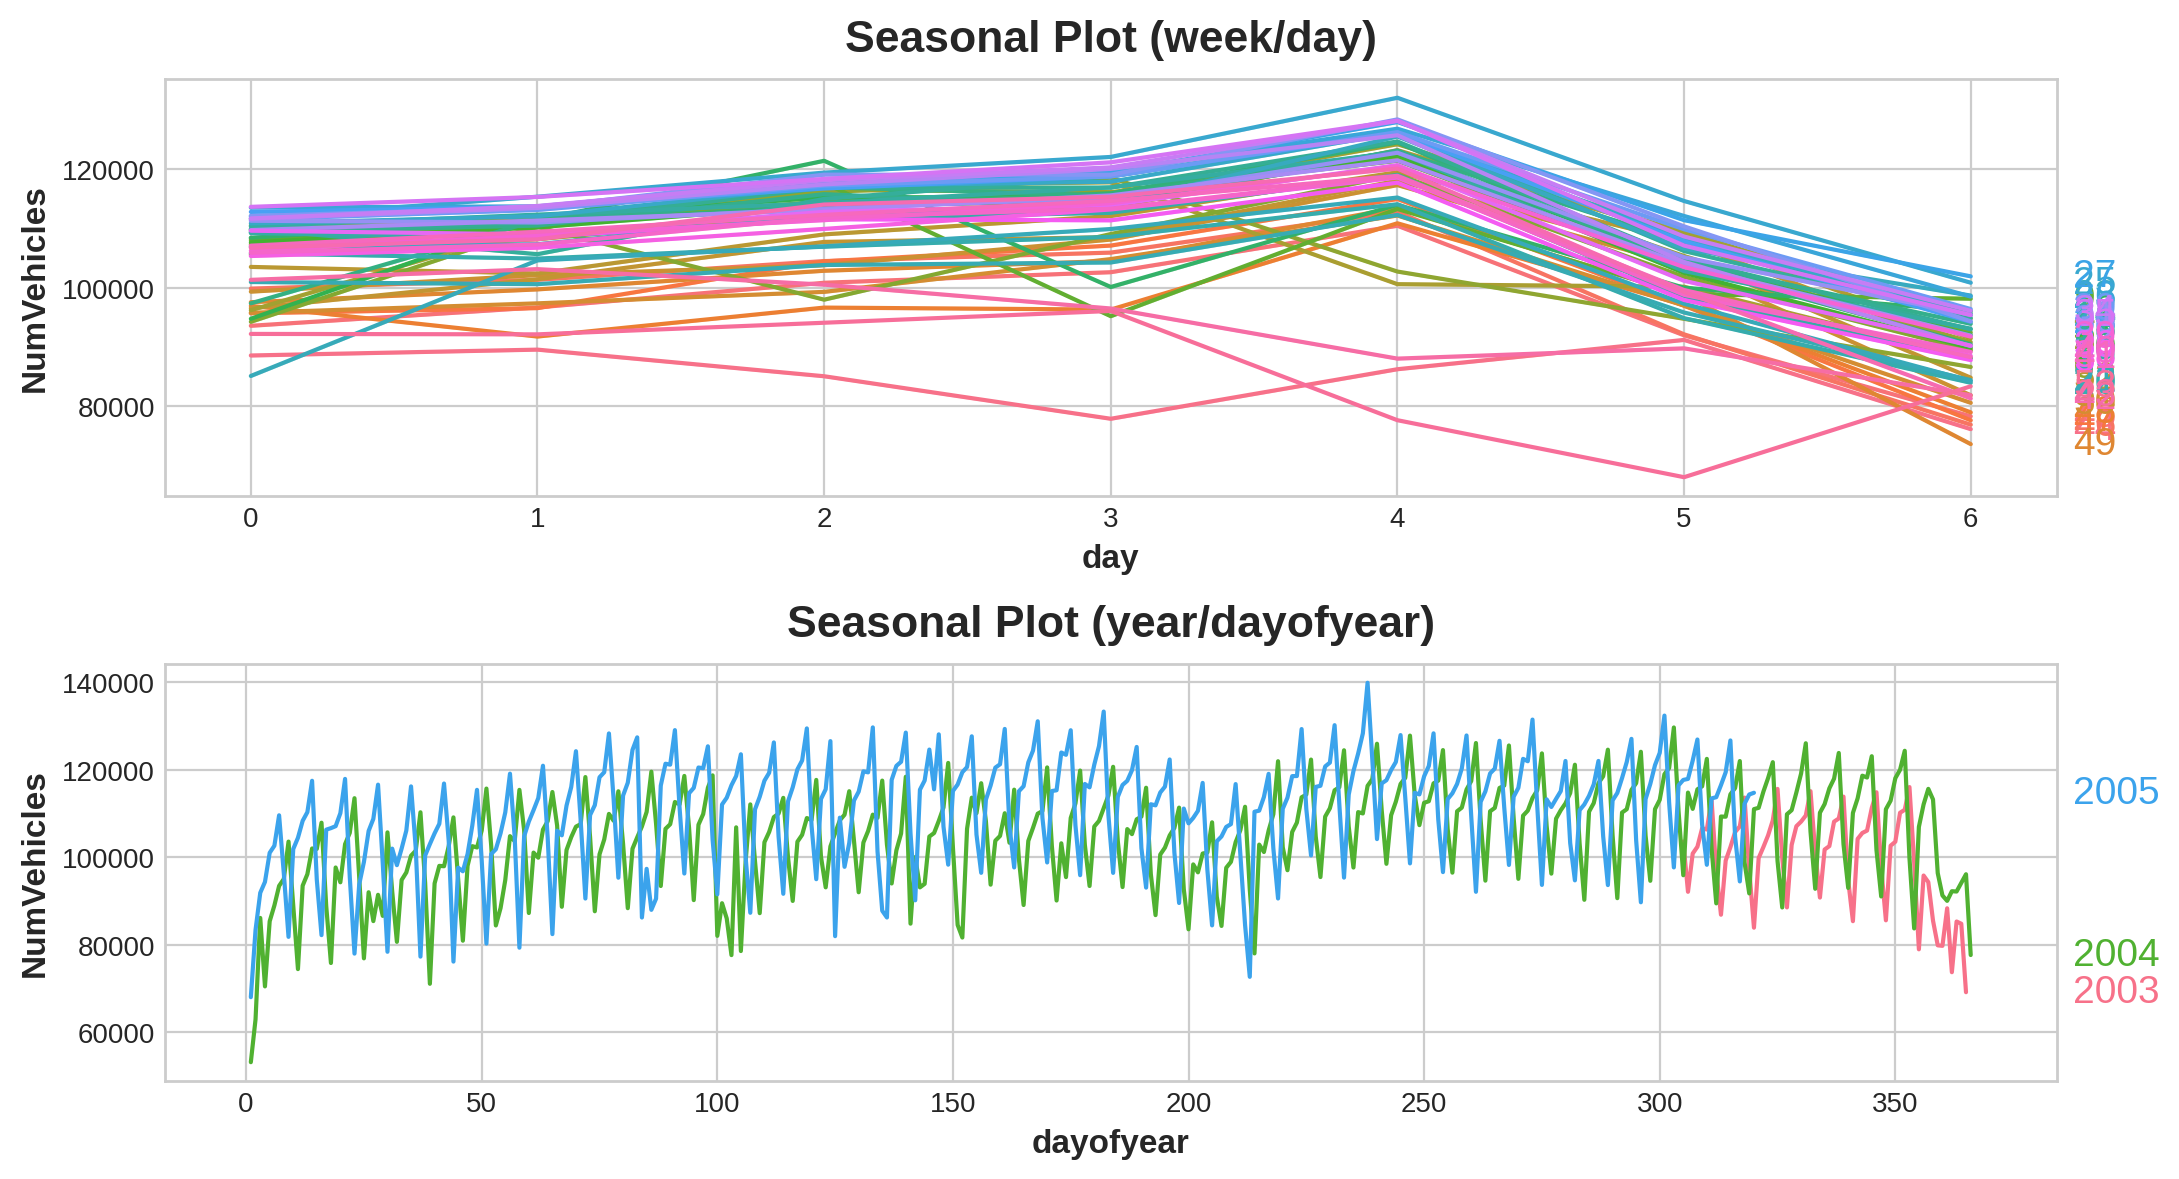

In [6]:
X = tunnel.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="NumVehicles", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="NumVehicles", period="year", freq="dayofyear", ax=ax1);

Now let's look at the periodogram:

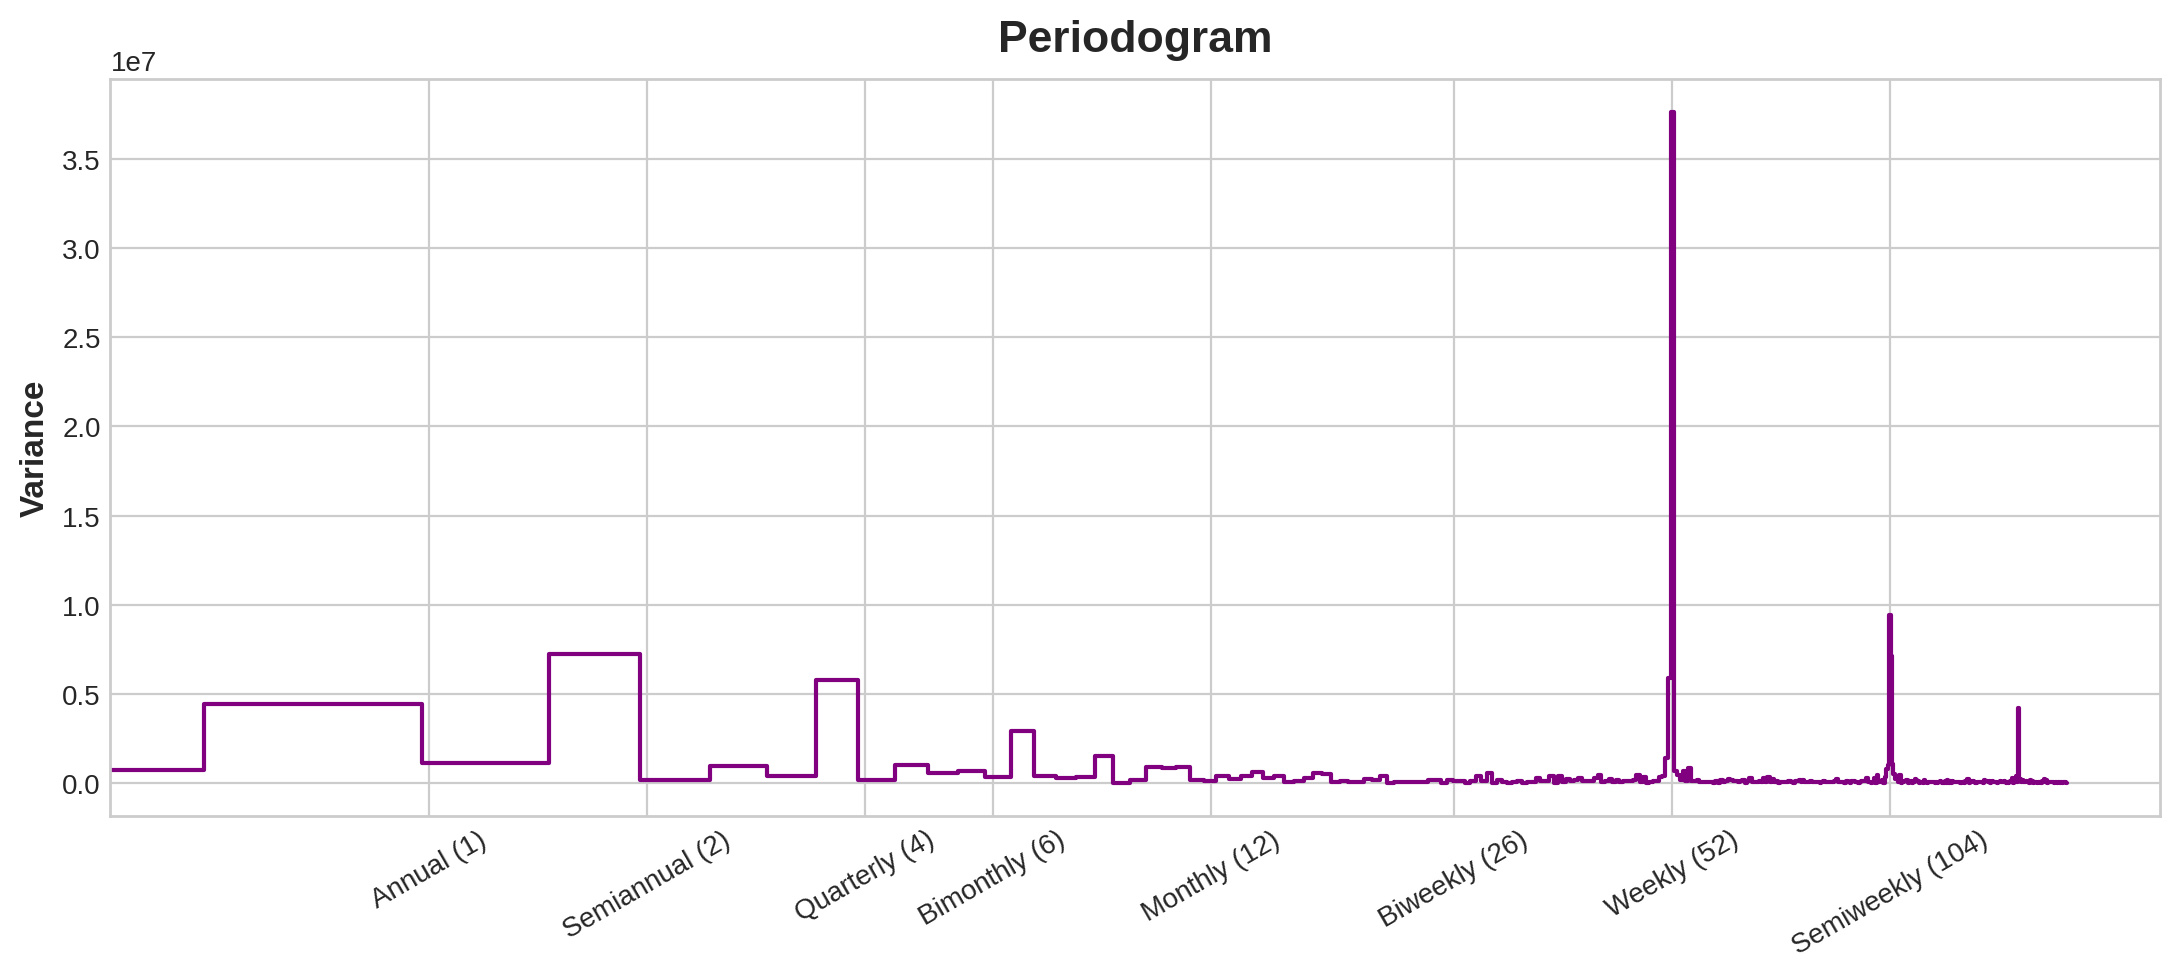

In [7]:
plot_periodogram(tunnel.NumVehicles);

The periodogram agrees with the seasonal plots above: a strong weekly season and a weaker annual season. The weekly season we'll model with indicators and the annual season with Fourier features. From right to left, the periodogram falls off between Bimonthly (6) and Monthly (12), so let's use 10 Fourier pairs.

We'll create our seasonal features using DeterministicProcess, the same utility we used in Lesson 2 to create trend features. To use two seasonal periods (weekly and annual), we'll need to instantiate one of them as an "additional term":

In [8]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=tunnel.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

With our feature set created, we're ready to fit the model and make predictions. We'll add a 90-day forecast to see how our model extrapolates beyond the training data. The code here is the same as that in earlier lessons.

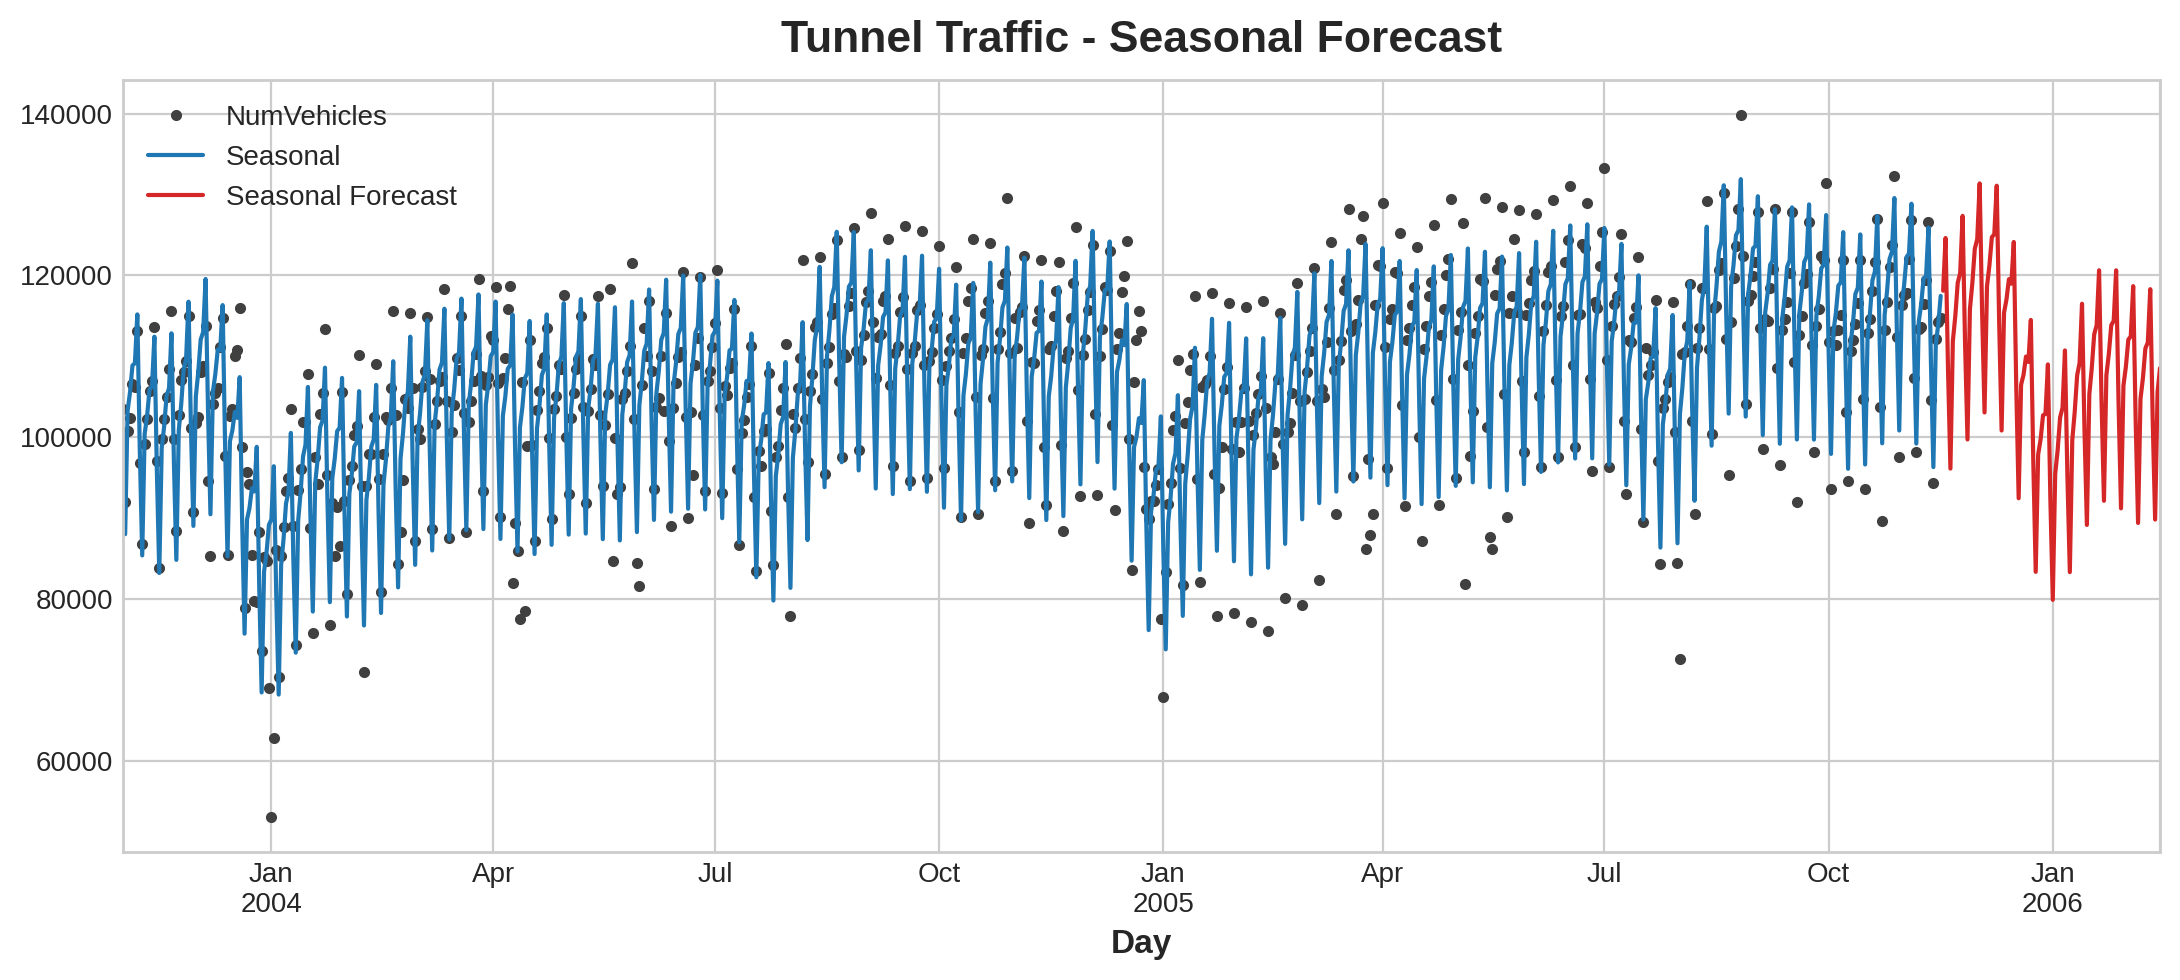

In [9]:
y = tunnel["NumVehicles"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

There's still more we can do with time series to improve our forecasts. In the next lesson, we'll learn how to use time series themselves as a features. Using time series as inputs to a forecast lets us model the another component often found in series: cycles.